In [1]:
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.layers.core import Lambda
from keras.layers import Input
import numpy as np
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.layers import Average
import matplotlib.pyplot as plt
from keras.applications.imagenet_utils import preprocess_input
%matplotlib inline

Using TensorFlow backend.


In [2]:
def ensembleModels(models, model_input):
    # taken from https://medium.com/@twt446/ensemble-and-store-models-in-keras-2-x-b881a6d7693f
    yModels=[model(model_input) for model in models]
    yAvg=Average()(yModels)
    modelEns = Model(inputs=model_input, outputs=yAvg, name='ensemble')
    return modelEns

In [3]:
input_tensor = Input(shape=(224, 224, 3))
tf_inputs = Lambda(lambda x: preprocess_input(x, mode='tf'))(input_tensor)
caffe_inputs = Lambda(lambda x: preprocess_input(x, mode='caffe'))(input_tensor)

base_inception = InceptionV3(input_tensor=input_tensor, weights="imagenet", include_top=True)
inception = Model(inputs=input_tensor, outputs=base_inception(tf_inputs))

base_densenet = DenseNet121(input_tensor=input_tensor, weights="imagenet", include_top=True)
densenet = Model(inputs=input_tensor, outputs=base_densenet(tf_inputs))

base_resnet = ResNet50(input_tensor=input_tensor, weights="imagenet", include_top=True)
resnet = Model(inputs=input_tensor, outputs=base_resnet(caffe_inputs))

base_vgg = VGG16(input_tensor=input_tensor, weights="imagenet", include_top=True)
vgg = Model(inputs=input_tensor, outputs=base_vgg(caffe_inputs))

base_xception = Xception(input_tensor=input_tensor, weights="imagenet", include_top=True)
xception = Model(inputs=input_tensor, outputs=base_xception(tf_inputs))

models = [inception, xception, resnet, densenet, vgg]

In [4]:
model_input = Input(shape=models[0].input_shape[1:])
ensemble = ensembleModels(models, model_input)
ensemble.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
for model in models:
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
X_exp = np.load('dl_experiments_data/imagenet/X_exp.npy')
Y_exp = np.load('dl_experiments_data/imagenet/Y_exp.npy')

In [ ]:
[model.evaluate(X_exp, Y_exp) for model in models]

In [ ]:
inception = InceptionV3(weights="imagenet",include_top=True)
inception.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
from deepvizkeras.guided_backprop import GuidedBackprop
from deepvizkeras.visual_backprop import VisualBackprop
from deepvizkeras.saliency import GradientSaliency

In [6]:
saliency_ensemble = GradientSaliency(ensemble)

In [ ]:
saliency_wrappers = [GradientSaliency(model) for model in models]

In [8]:
saliency_ensemble_monkey = saliency_ensemble.get_smoothed_mask(X_exp[2] - 127.5)

In [13]:
saliency_ensemble_bird = saliency_ensemble.get_smoothed_mask(X_exp[7] - 127.5)

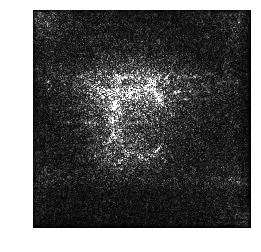

In [14]:
show_image(saliency_ensemble_bird, title='ensemble_bird')

In [ ]:
masks = [wrapper.get_smoothed_mask(X_exp[2] - 127.5) for wrapper in saliency_wrappers]

In [ ]:
show_image(X_exp[2] - 127.5, 'monkey', grayscale=False)

In [ ]:
for i in xrange(5):
    show_image(masks[i], 'monkey_{}'.format(i))

In [ ]:
plt.imshow(X_exp[2]/255.0)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def show_image(image, title, grayscale = True, ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    if len(image.shape) == 2 or grayscale == True:
        if len(image.shape) == 3:
            image = np.sum(np.abs(image), axis=2)
            
        vmax = np.percentile(image, 99)
        vmin = np.min(image)

        plt.imshow(image, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
#         plt.title(title)
        plt.savefig("saliency_ims/{}.png".format(title))
    else:
        image = image + 127.5
        image = image.astype('uint8')
        
        plt.imshow(image)
        plt.savefig("saliency_ims/{}.png".format(title))



In [ ]:
import os

In [ ]:
os.mkdir('saliency_ims')